In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from numpy import mean
from sklearn.model_selection import GridSearchCV
import pickle 
from scipy import stats
from scipy.stats import norm, lognorm, powerlaw, skew
import warnings

warnings.filterwarnings("ignore")

#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
#https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis


# Introduction and Data Sourcing
This analysis provided is of the US army body composition dataset which contains information on body fat percentage and other physical characteristics of US army soldiers. Included is exploratory data analysis techniques, dimension reduction methods, and model construction for the prediction of body fat percentage. The final model is a partial least squares regression with a **5-fold cross validation RMSE of .719.**

### Data Science techniques used in this notebook:
- EDA.
- PCA.
- Data set segmentation and K-fold cross validation.
- Regression modeling (OLS, PLS, PCR, Ridge, Lasso, ElasticNet, and SVR).

### Credit for the density elipse function and some PCA visualizations: 
- https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
- https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis

In [3]:
armydata = pd.read_csv(r"C:\Users\Localadmin\DataScienceData\ArmyBodyData-1.csv")
#Loads in the dataset. 
armydata.head()
#Visually inspect the data

,Validation,%BodyFat,BMI,AgeYrs,Height,Wt lbs,Inseam,Lat Fem Epi,Trocanter,Forearm Length,...,Foot Length,Wrist Circ,Hand Length,Hand Width,Thigh Circ,Nose Width,Biocular Dist,Ear Length,Outseam Omphalion,Waist Circ
0,Validation,25.79,29.27,34.66,68.31,194.26,30.75,19.45,35.94,11.46,...,10.24,7.01,7.60,3.58,24.69,1.41,5.10,2.76,40.51,38.66
1,Validation,25.98,25.77,37.28,72.05,190.30,35.47,21.89,39.17,12.01,...,11.42,7.17,8.39,3.82,24.21,1.24,4.91,2.83,44.41,38.43
2,Training,19.62,23.88,38.97,67.95,156.86,30.94,19.09,34.80,11.06,...,10.00,6.61,7.52,3.54,22.68,1.31,4.82,2.83,40.31,33.27
3,Validation,19.66,25.61,33.59,70.20,179.52,32.72,19.37,35.83,11.54,...,10.67,6.93,8.03,3.54,24.25,1.44,5.14,2.52,41.54,34.80
4,Validation,29.93,27.08,42.03,65.71,166.32,30.91,19.45,33.74,10.94,...,9.45,6.42,6.93,3.27,23.11,1.22,4.21,2.56,38.50,38.03


## Data Cleaning and Processing
The dataset provided has already been pre-processed so minimal data cleaning is required, however for thoroughness we will check for missing values. Next, I drop the validation column, originally included for use in other proprietary software, as scikit provides its own methods for cross-validation and train/test splitting.



In [4]:
armydata.isnull().sum()
#Check for missing values

Validation           0
%BodyFat             0
BMI                  0
AgeYrs               0
Height               0
Wt lbs               0
Inseam               0
Lat Fem Epi          0
Trocanter            0
Forearm Length       0
Chest                0
Neck                 0
Sleeve               0
Foot Width           0
Foot Length          0
Wrist Circ           0
Hand Length          0
Hand Width           0
Thigh Circ           0
Nose Width           0
Biocular Dist        0
Ear Length           0
Outseam Omphalion    0
Waist Circ           0
dtype: int64

In [5]:
armydata = armydata.drop(columns = "Validation")
#Remove unnecessary validation column

## Exploratory Data Analysis
Looking at our data table we see that most of our variables appear to be continuous. We verify this by checking the dataframe attribute *dtypes* which reveals that all variables are indeed float64. As our variables are  continuous a good first principle of data exploration is to look at their sampling distributions. To do so we loop through the columns and plot the distribution using the seaborn histogram function.

In [6]:
armydata.dtypes

%BodyFat             float64
BMI                  float64
AgeYrs               float64
Height               float64
Wt lbs               float64
Inseam               float64
Lat Fem Epi          float64
Trocanter            float64
Forearm Length       float64
Chest                float64
Neck                 float64
Sleeve               float64
Foot Width           float64
Foot Length          float64
Wrist Circ           float64
Hand Length          float64
Hand Width           float64
Thigh Circ           float64
Nose Width           float64
Biocular Dist        float64
Ear Length           float64
Outseam Omphalion    float64
Waist Circ           float64
dtype: object

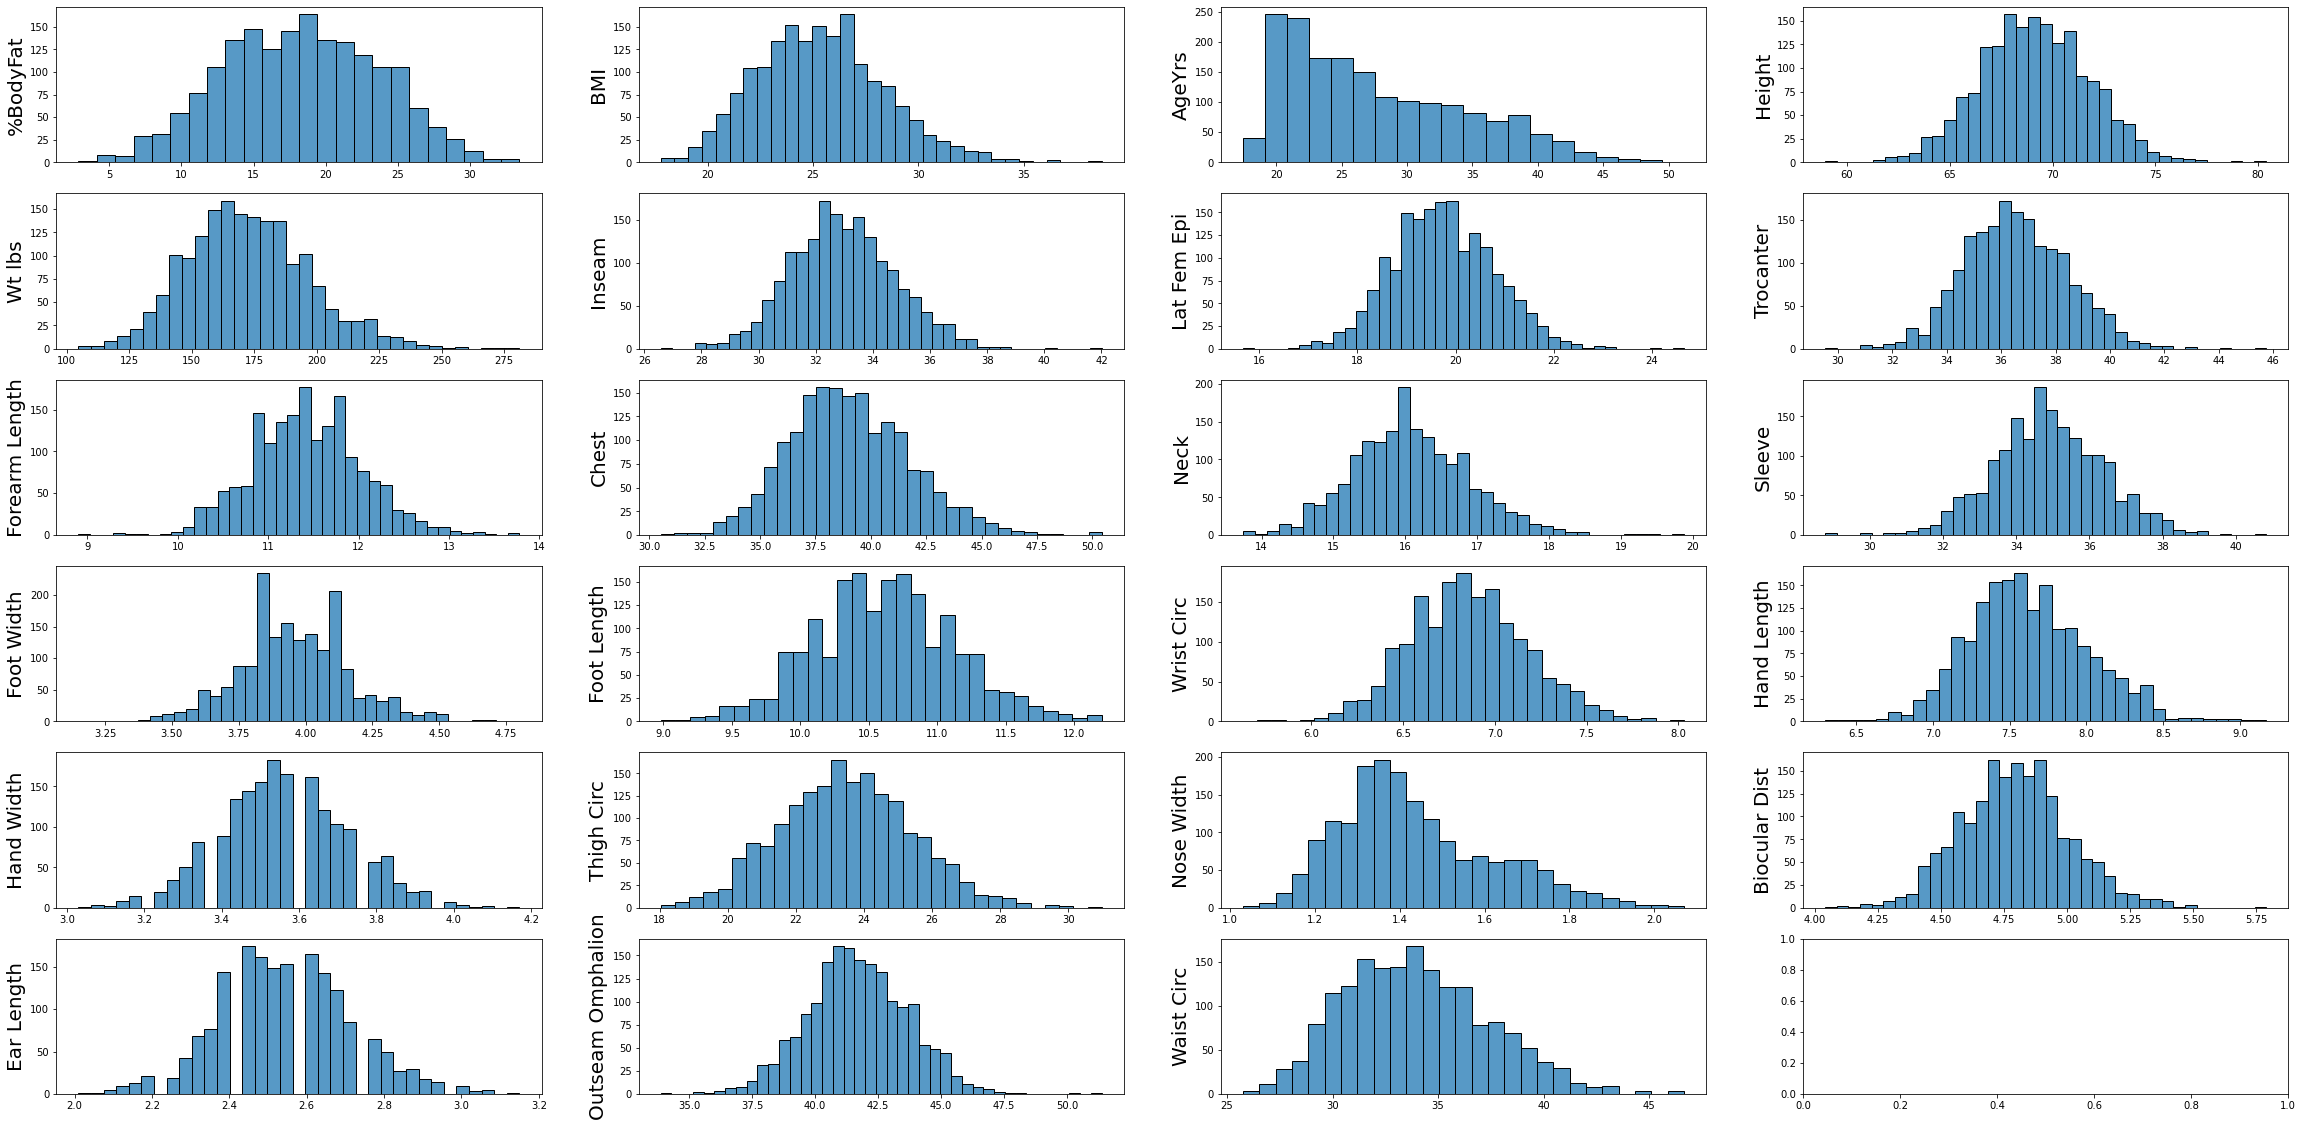

In [7]:
columns = []
for col in armydata.columns:
    columns.append(col)
#Get a list of column names 

#Plot distributions 
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(40,20))
for i, col in enumerate(columns, 1):
    plt.subplot(6, 4 , i)
    sns.histplot(x=col, data=armydata)
    plt.ylabel('{}'.format(col), size=20)
    plt.xlabel('')


## Probability Distributions
All of our sampling distributions appear to be normally distributed, or at least normal-like. This is very good as one of the assumptions for OLS linear models is the normality of the target variable. The only distribution which appears to be non-normal is "AgeYrs," which by visual inspection appears to be fat-tailed. We can further explore this by using the seaborn function distplot, which plots the histogram alongside a kernel density estimate, additionally we add a log-normal fit to the plot. 

In the above plot there appears to be an issue in the sampling "Ear Length," and "Hand Width," however further investigation, provided below by plotting the features with pre-specified bin counts, reveals this is merely the result of the automatic bin calculation by the seaborn function.



<AxesSubplot:xlabel='AgeYrs', ylabel='Density'>

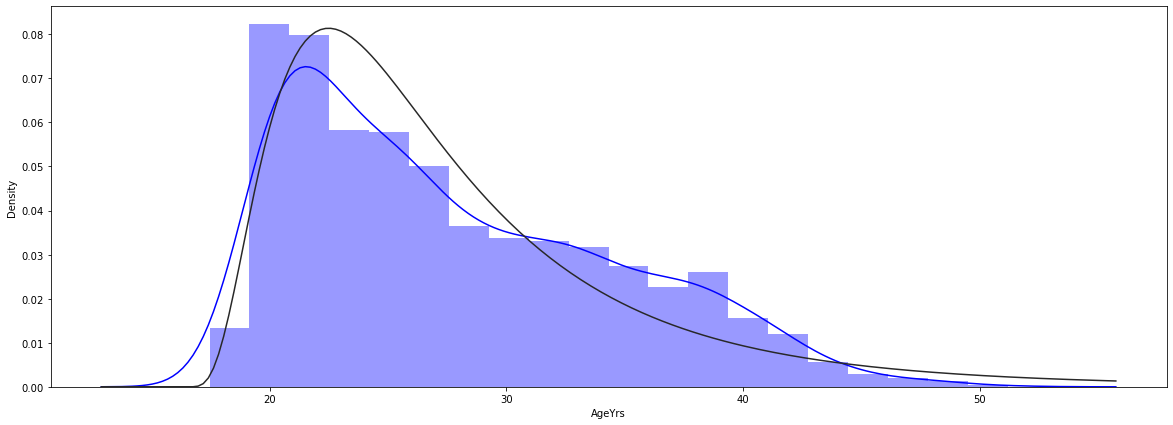

In [8]:
#Plot lognormal approximation
fig, (axs1) = plt.subplots(ncols = 1, figsize =(20, 7))
sns.distplot(armydata['AgeYrs'], color = 'blue', fit=lognorm, ax = axs1)


<AxesSubplot:xlabel='Ear Length', ylabel='Count'>

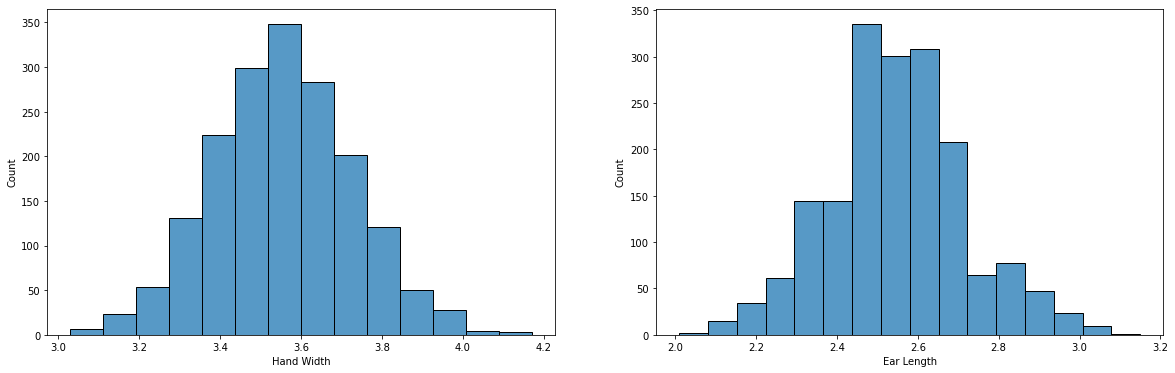

In [9]:
#armydata['Hand Width']
fig, (axs1, axs2) = plt.subplots(ncols=2, nrows=1, figsize=(20,6))
sns.histplot(x='Hand Width', data = armydata, bins=14, ax =axs1)
sns.histplot(x='Ear Length', data = armydata, bins=16, ax =axs2)


## EDA continued 
Having investigated the distributions of our independent variables  we now want to investigate the relationships between the variables. One of the best statistics to investigate linear relationships between variables is Pearson's Correlation coefficient which is a standardized version of the covariance between two variables. Provided below is a heatplot of correlations between these variables. The darker the color on the heatmap the higher the positive correlation. 

Next, we have a scatter matrix of all variables. This visual is a collection of scatterplots which plot the relationships between the variables at an observation level. Variables selected for this visualization were chosen based on the results of the correlation heatmap. 

<AxesSubplot:>

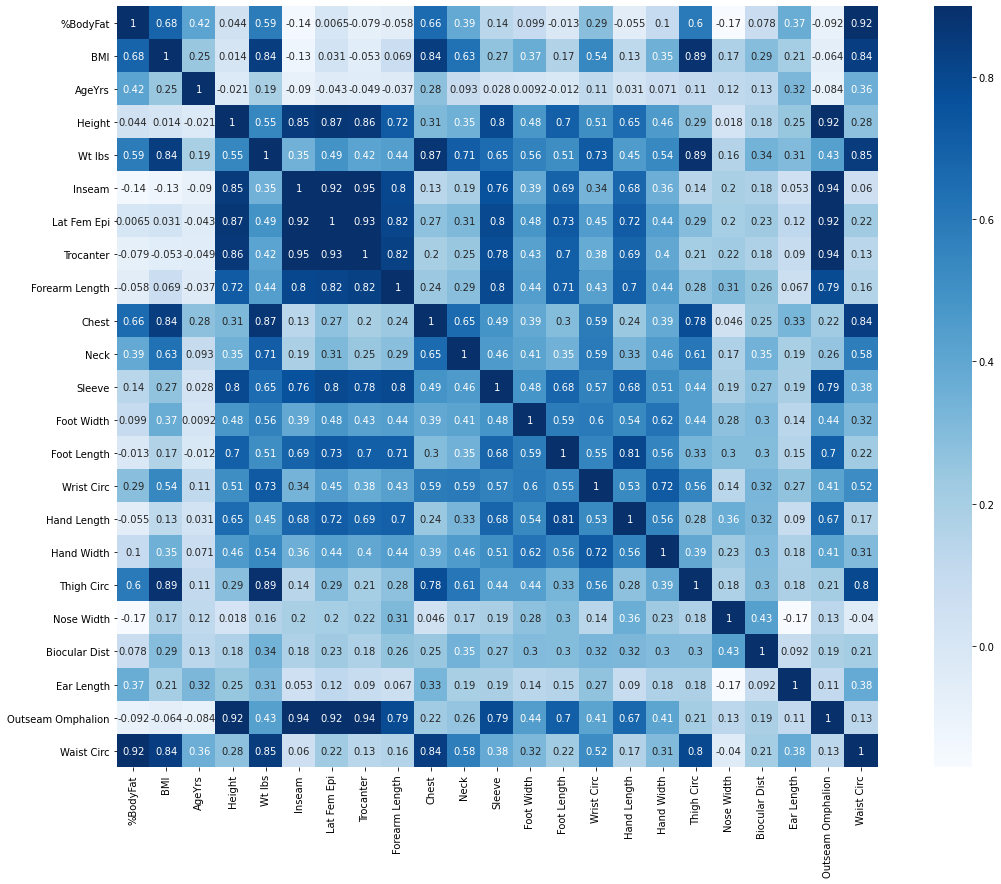

In [10]:
#Heat map of correlations 
corrmat = armydata.corr()
plt.subplots(figsize=(20,14))
sns.heatmap(corrmat, vmax=0.9, cmap = 'Blues', annot = True, square=True)

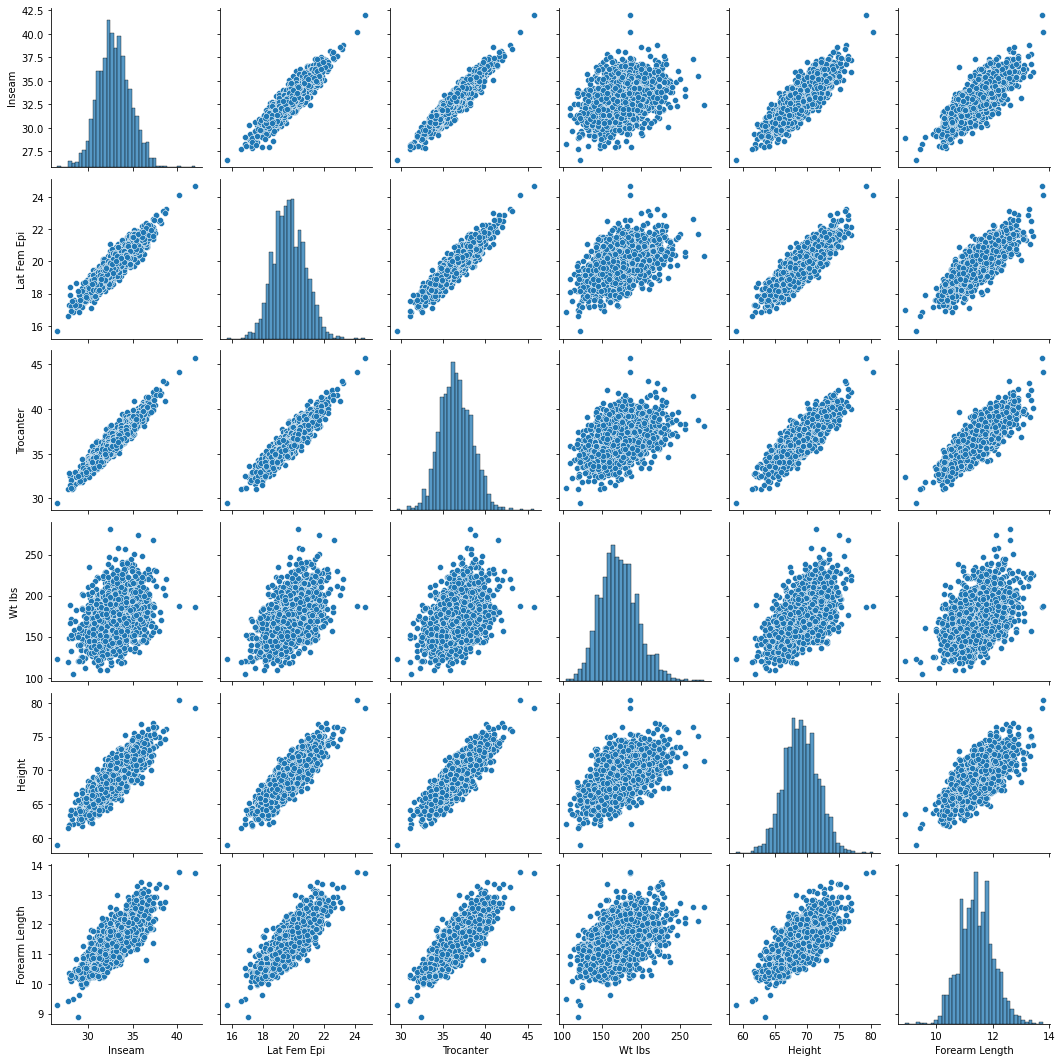

In [11]:
#Scatter matrix 
sns.pairplot(data = armydata, vars= [ 'Inseam', 'Lat Fem Epi', 'Trocanter', 'Wt lbs', 'Height', 'Forearm Length'])

## Principal Component Analysis 
We see from our scatter and correlation matrix that our variaables seem to have a strong linear relationship with one another. If we attempt to model with this data it is likely we will run into issues with multicolinearity which could destabalize our regression. One interesting way around this is through Principal Component Analysis which is often used in Data Science/Data analysis fields as a method of dimension reduction. Another aspect of it is that is a method of unsupervized learning. 

PCA (principal component ananlysis) Creates a set of mutually orthogonal vectors which take the direction of the maximum variance in our data. Using these vectors as a new coordinate set we can transform our data. Provided below is the code to do this in python. 

In [29]:
#seperate data into response and features
y = armydata['%BodyFat']
X = armydata[armydata.columns[1:23]]

In [30]:
#Scale x values
scaler= StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [43]:
#apply pca to x calues
pca = PCA(n_components=22)
Principal_components = pca.fit_transform(scaled_X)
pcascores = []
for i in range(len(X.columns)):
    pcascores.append("PC " + str(i +1))

In [44]:
#Create dataframe
pca_df = pd.DataFrame(data = Principal_components, columns = pcascores)
pca_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22
0,-1.016031,-3.551755,-0.113403,0.915014,-0.480951,1.581071,-1.292105,-1.277328,0.348475,0.526194,...,0.408287,0.564941,0.051487,0.171133,0.051705,0.064054,0.557219,-0.049959,-0.100259,-0.026842
1,-4.854479,0.572448,-1.432832,1.713170,0.990495,-0.141575,-0.204500,0.400556,-0.767041,0.431937,...,0.155607,0.452298,0.637806,0.069222,0.598534,0.298156,0.099279,0.106525,0.112693,0.025009
2,2.060913,-1.136769,-0.949782,2.111407,0.392033,0.486574,-0.461621,-0.470543,0.288065,0.120835,...,-0.255220,0.483320,-0.197494,-0.394840,-0.202834,0.450245,0.123256,-0.060288,0.213887,0.012978
3,-1.171078,-0.751443,1.213024,0.693605,0.267883,0.671152,-0.542253,0.660871,0.263620,1.449804,...,0.277192,0.919642,-0.596872,-0.067510,-0.259254,-0.181440,-0.190487,0.063565,0.185432,-0.004761
4,4.216299,-2.653217,-2.535977,0.546941,-1.212125,-2.171980,-0.003897,0.232382,1.028578,0.276947,...,0.586299,0.545269,1.007989,0.170672,-0.109184,0.721748,-0.422961,0.033073,-0.358641,-0.032038


## Scree Plot
PCA creates its principal components based on the direction of the maximum variance of the orignal variables. This distance is represented by the eigenvalue, we can then take the percentage of the total for each principal components eigenvalue. When we do this and plot all of the results we get the scree plot depicted below. Using the scree plot we can then determine which principal components to retain in our analysis (this is typically done by finding an apparent inflection point.) 

Below the Scree plot is the PC-Score plot for the first and second principal component. This plots the principal component "scores" (the data as transformed in the new coordinate system.) We use this plot to perform diagnostics and see whether or not PCA was succesful in creating mutually orthogonal regressors. We should see a random scatterplot, which is what is provided, a density elipse is provided for reference.  

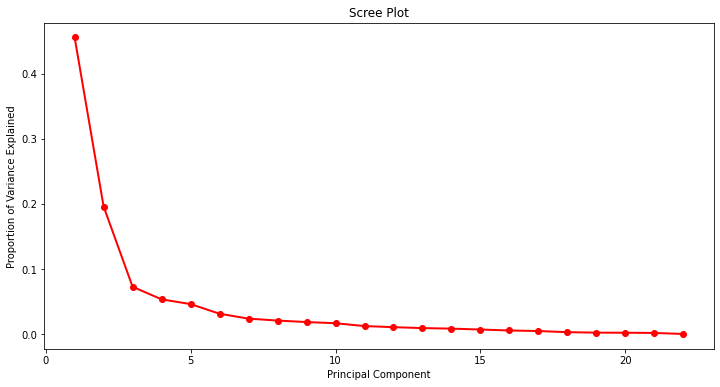

In [45]:
#Scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(12, 6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [46]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

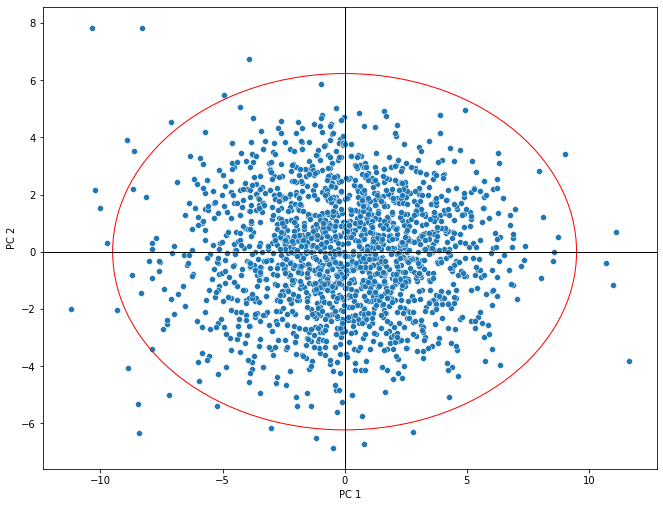

In [47]:
#PC Scores plot 
fig, ax = plt.subplots(figsize=(11, 8.5))
sns.scatterplot(x ='PC 1', y= 'PC 2', data=pca_df)
ax.axhline(y=0, color='k', linewidth=1)  
ax.axvline(x=0, color='k', linewidth=1)
confidence_ellipse(pca_df['PC 1'], pca_df['PC 2'], ax, edgecolor='red')


## Loading Matrix
PCA reduces the data intwo two matrices, the loading and scores matrix. For our purposes we can interpret the loadings matrix to investigate the relationships between the original variables and their principal component counterparts. The absolute values of the entries in the loadings matrix denote the strength which the principal component is associated with the original variable. We can normalize these to get percentages. Provided below is the unaltered loadings matrix.

In [48]:
#Loading matrix 
loadings = pd.DataFrame(pca.components_.T, columns=pcascores, index=X.columns)
loadings

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22
BMI,-0.144387,-0.406581,0.061622,-0.123991,-0.126583,-0.084336,0.123559,0.003093,-0.084095,-0.059901,...,0.019893,0.013592,0.092766,-0.156290,0.166284,-0.187228,0.115683,0.175837,-0.494011,-0.599878
AgeYrs,-0.030150,-0.167362,-0.066203,0.727684,-0.155790,-0.433183,-0.337233,0.170877,0.058096,0.132079,...,0.114243,-0.009296,-0.105852,-0.184167,0.027935,0.029704,-0.006522,-0.008903,-0.002519,0.001271
Height,-0.262216,0.171699,-0.229710,0.006476,0.034270,0.098827,-0.096914,0.102226,0.103599,0.063312,...,-0.043749,0.000203,-0.401245,0.189282,-0.528458,0.065661,-0.154880,-0.251712,-0.170516,-0.394577
Wt lbs,-0.260961,-0.248511,-0.069990,-0.099196,-0.089197,-0.014273,0.052120,0.056699,-0.017533,-0.018464,...,-0.007203,0.012330,-0.142217,-0.024881,-0.152220,-0.125509,-0.004417,-0.006713,-0.536069,0.695666
Inseam,-0.238679,0.277259,-0.094311,-0.000457,-0.149184,0.008894,-0.024514,0.069799,0.091253,-0.065454,...,-0.037116,-0.003148,0.178687,-0.133602,0.257130,-0.360154,-0.733363,0.108291,0.017910,-0.006228
Lat Fem Epi,-0.266324,0.206290,-0.094018,-0.005884,-0.123587,0.007993,-0.002980,0.070507,0.078581,-0.009504,...,0.058815,0.107815,0.282805,0.054305,0.321942,0.743382,0.037645,-0.082174,-0.243700,-0.001328
Trocanter,-0.251816,0.246660,-0.098495,0.011176,-0.156280,-0.028291,-0.009440,0.022146,0.139297,-0.075057,...,0.035255,-0.003822,0.204355,-0.041971,0.139871,-0.440430,0.521294,-0.507748,0.082288,0.002185
Forearm Length,-0.248568,0.188118,0.035452,0.008899,-0.149645,-0.047449,0.040330,-0.145567,-0.110329,-0.222441,...,0.524308,0.045346,0.193784,0.008152,-0.350003,0.023506,-0.053063,0.032353,-0.013800,-0.000871
Chest,-0.196578,-0.316665,-0.140277,-0.049750,-0.125897,-0.036924,-0.018903,-0.014407,-0.001873,-0.009988,...,-0.502527,-0.384583,0.426859,-0.147528,-0.303779,0.151274,-0.082076,-0.145665,0.216601,0.002674
Neck,-0.193278,-0.220387,0.059749,-0.135884,0.006834,0.240839,-0.413165,-0.493416,0.411937,0.432890,...,0.155468,0.049069,-0.002005,-0.040571,0.059845,-0.012853,-0.017382,0.025803,0.060962,0.003516


## Model Building 
As we noted in the beginning of this notebook the purpose of the Principal Component Analysis was to reduce multi-collinearity in our modeling process, not dimension reduction, hence our PCA retained all twenty-two principal components. Given that we retained all of the principal components, it is highly likely that some of these are non-informative in relation to our response variable, to compensate for this we must use feature selection methods. Three are selected below, ElasticNet, Lasso, and Ridge, all three are extremely similar, based on the concept of introducing bias into our model. The ridge regression model is optimized using the following function $  e = \hat Y  - \left(X \beta + \lambda \beta \beta ^T \right)$, in the case of lasso regression the square term of the slop estimates is replaced with an absolute value. This square term penalizes the effect of non-informative features. Elastic Net combines the two methods, alternating between the two for each feature and cross-validating to select the best performing method. I utilize all three methods both on our PCA transformed data and the original data. The 5-fold cross-validation error is provided below. We see that our OLS estimate tends to outperform the PCA transformed variables.

Below this are a number of other linear/non-linear models, our highest performing is PLS (Partial Least Squares) which is similar to PCR (Principal Component Regression) in that it transforms our variables to perform the regression. 

In [55]:
print("PCR:")
model = ElasticNet()
scores = cross_val_score(model, pca_df, y, cv=5, scoring = "neg_root_mean_squared_error")
print('Elastic Net Neg-RMSE : %.3f' % (mean(scores)))
model= Lasso()
scores = cross_val_score(model, pca_df, y, cv=5, scoring = "neg_root_mean_squared_error")
print('Lasso Neg-RMSE: %.3f' % (mean(scores)))
model=Ridge()
scores = cross_val_score(model, pca_df, y, cv=5, scoring = "neg_root_mean_squared_error")
print('Ridge Neg-RMSE: %.3f' % (mean(scores)))

print("OLS:")
model = ElasticNet()
scores = cross_val_score(model, X, y, cv=5, scoring = "neg_root_mean_squared_error")
print('Elastic Net Neg-RMSE : %.3f' % (mean(scores)))
model= Lasso()
scores = cross_val_score(model, X, y, cv=5, scoring = "neg_root_mean_squared_error")
print('Lasso Neg-RMSE: %.3f' % (mean(scores)))
model=Ridge()
scores = cross_val_score(model, X, y, cv=5, scoring = "neg_root_mean_squared_error")
print('Ridge Neg-RMSE: %.3f' % (mean(scores)))


PCR:
Elastic Net Neg-RMSE : -3.000
Lasso Neg-RMSE: -3.154
Ridge Neg-RMSE: -0.725
OLS:
Elastic Net Neg-RMSE : -1.204
Lasso Neg-RMSE: -1.038
Ridge Neg-RMSE: -0.719


In [63]:
model = SVR()
scores = cross_val_score(model, X, y, cv=5, scoring ="neg_root_mean_squared_error")
print('SVR Neg-RMSE: %.3f' % (mean(scores)))
model = LinearRegression()
scores = cross_val_score(model, pca_df, y, cv=5, scoring = "neg_root_mean_squared_error")
print('PCR Neg-RMSE: %.3f' % (mean(scores)))
model = PLSRegression(n_components=22)
scores = cross_val_score(model, X, y, cv=5, scoring = "neg_root_mean_squared_error")
print('PLS Neg-RMSE: %.3f' % (mean(scores)))
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring = "neg_root_mean_squared_error")
print('OLS Neg-RMSE: %.3f' % (mean(scores)))
model=XGBRegressor()

SVR Neg-RMSE: -3.620
PCR Neg-RMSE: -0.719
PLS Neg-RMSE: -0.719
OLS Neg-RMSE: -0.719


## Feature Selection 
An alternative to ridge/lasso methods, which introduce bias as part of the functional form of the linear model, is to do feature selection based on subsetting the available regressors (often called stepwise regression.) However, stepwise regression has not been implemented in python's scikit learn, though they have introduced a similar feature ranking algorithm. Below are the cross-validation errors plotted as features are introduced into the model for PCR, PLS and OLS with feature selection. We see that all three provide similar results, though the feature selected untransformed variables do ultimately end up predicting the best results. For simplicity sake we will save the full linear regression model for use in deployment. 

[-5.183656081075428, -3.529131034729184, -2.997322490282264, -2.947337487132903, -2.7976146196316565, -2.7805785659102416, -2.779892118469473, -2.721235889719841, -2.695289546219993, -2.6894488886789056, -2.681886029733622, -2.63790911550049, -2.5939091672944707, -2.552731850304009, -2.4994240608360334, -1.403164550237839, -1.3335409804360674, -1.3338384467270277, -1.3358629731737788, -1.3037657992342084, -0.8426066293593137, -0.7190064967152214]


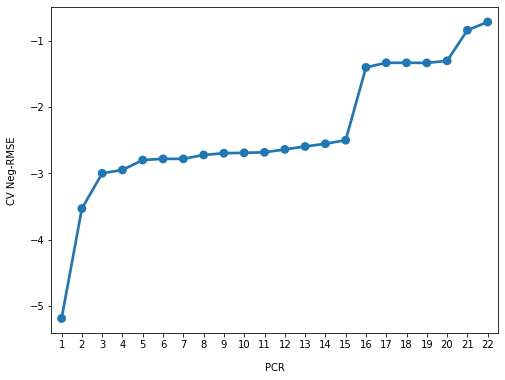

In [65]:
scores = []
for i in range(1,23):
    model  = LinearRegression()
    score = mean(cross_val_score(model, pca_df[pca_df.columns[0:i]], y, cv=5, scoring = "neg_root_mean_squared_error"))
    scores.append(score)
fig = plt.figure(figsize=(8, 6))
sns.pointplot(y=scores, x = list(range(1,23)), markers=['o'], linestyles=['-'])
plt.ylabel('CV Neg-RMSE', size=10, labelpad=12.5)
plt.xlabel('PCR', size=10, labelpad=12.5)
print(scores)

[-3.9286018858583738, -3.7231800610382293, -3.6306979346785213, -3.581810273529645, -3.5165413232807765, -3.510582007812604, -3.3833705130786256, -3.3833238140603354, -0.9410535889791365, -0.9402623154800445, -0.7223716737036223, -0.7222651876539695, -0.723149928443762, -0.720706976783936, -0.720831233338651, -0.7214532560583049, -0.7208458224161729, -0.7165056543112838, -0.7176987951016399, -0.7179271084498301, -0.7180917625683468, -0.71900649671522]


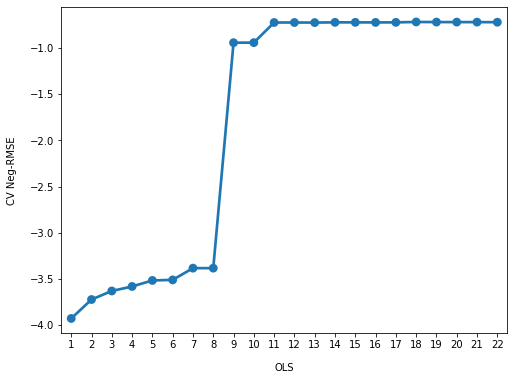

In [66]:
scores = []
estimator = LinearRegression()
model = RFE(estimator)
selector = model.fit(X, y)
rankings = list(selector.ranking_)
sorted_features =  [x for _,x in sorted(zip(rankings,list(X.columns)))]
X_sorted = X.reindex(sorted_features, axis = 1) 
for i in range(1,23):
    model  = LinearRegression()
    score = mean(cross_val_score(model, X_sorted[X_sorted.columns[0:i]], y, cv=5, scoring = "neg_root_mean_squared_error"))
    scores.append(score)
fig = plt.figure(figsize=(8, 6))
sns.pointplot(y=scores, x = list(range(1,23)), markers=['o'], linestyles=['-'])
plt.ylabel('CV Neg-RMSE', size=10, labelpad=12.5)
plt.xlabel('OLS', size=10, labelpad=12.5)
print(scores)

[-3.4508417117043977, -2.906868013049166, -2.430810002506031, -1.8056760625944794, -1.3001371245580304, -1.0846334192432734, -1.0235812480190765, -0.9551408470080119, -0.8869321406496263, -0.8287546943709151, -0.8201290919600467, -0.8171678443272408, -0.8086223232592304, -0.7856815819676027, -0.7615810313967322, -0.7397212443354779, -0.7249383355906722, -0.7203789162054541, -0.7193605778312654, -0.7193631393473424, -0.7190002348957656, -0.7190064967152203]


'BMI'

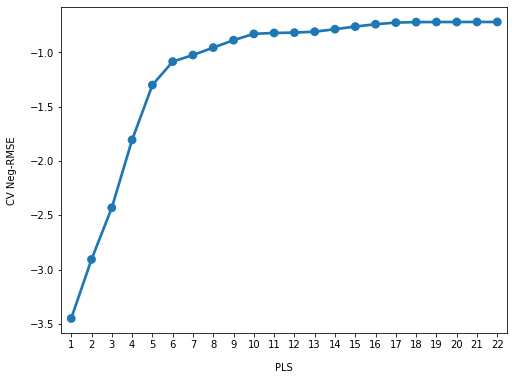

In [67]:
scores = []
for i in range(1,23):
    model  = PLSRegression(n_components = i)
    score = mean(cross_val_score(model, X, y, cv=5, scoring = "neg_root_mean_squared_error"))
    scores.append(score)
fig = plt.figure(figsize=(8, 6))
sns.pointplot(y=scores, x = list(range(1,23)), markers=['o'], linestyles=['-'])
plt.ylabel('CV Neg-RMSE', size=10, labelpad=12.5)
plt.xlabel('PLS', size=10, labelpad=12.5)
print(scores)
X.columns[0]

In [68]:
lm = LinearRegression()
finalmodel = lm.fit(X, y)
import pickle
pickl = {'model': finalmodel}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )